In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

# Bài toán

Xây dựng kho dữ liệu về đặc điểm môn học (lý thuyết, thực hành, thiết kế, kỹ thuật, công nghệ, …) và điểm số mà các sinh viên đã học. Khai phá dữ liệu này cho mục đích gợi ý chọn chuyên ngành cho sinh viên.

# Load dataset

## Đọc dataset

In [2]:
df = pd.read_csv('/kaggle/input/student-gpa/student_data.csv')

## Các thông số cơ bản của bộ dữ liệu¶

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93532 entries, 0 to 93531
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   student_id                93532 non-null  int64  
 1   student_name              93532 non-null  object 
 2   student_current_semester  93532 non-null  int64  
 3   student_current_gpa       93532 non-null  float64
 4   subject_code              93532 non-null  object 
 5   subject_name              93532 non-null  object 
 6   subject_credits           93532 non-null  int64  
 7   subject_category          93532 non-null  object 
 8   subject_type              93532 non-null  object 
 9   no_theory                 93532 non-null  int64  
 10  no_practice               93532 non-null  int64  
 11  attendance_percentage     93532 non-null  float64
 12  midterm_percentage        93532 non-null  float64
 13  final_percentage          93532 non-null  float64
 14  assign

Bộ dữ liệu gồm 15 cột có kiểu dữ liệu số và 7 cột có kiểu dữ liệu chữ

In [4]:
print(f"Shape của dataset: {df.shape}")
print(f"Số lượng sinh viên: {df['student_id'].nunique()}")
print(f"Số lượng môn học: {df['subject_code'].nunique()}")
print(f"Số lượng chuyên ngành gợi ý: {df['recommendation_major'].nunique()}")
print(f"Danh sách chuyên ngành: {df['recommendation_major'].unique()}")

Shape của dataset: (93532, 22)
Số lượng sinh viên: 6684
Số lượng môn học: 16
Số lượng chuyên ngành gợi ý: 3
Danh sách chuyên ngành: ['An toàn thông tin' 'Công nghệ phần mềm' 'Trí tuệ nhân tạo']


In [5]:
df.head()

,student_id,student_name,student_current_semester,student_current_gpa,subject_code,subject_name,subject_credits,subject_category,subject_type,no_theory,...,midterm_percentage,final_percentage,assignment_percentage,final_grade,midterm_grade,assignment_grade,attendance_grade,retake_count,skill_list,recommendation_major
0,10000,Vũ Quang Phương,5,5.35,BAS1226,Xác suất thống kê,3,theory,core,30,...,30.0,50.0,10.0,3.2,5.0,7.1,7.8,0,"Phân tích dữ liệu, Xử lý số liệu, Thống kê",An toàn thông tin
1,10000,Vũ Quang Phương,5,5.35,INT1313,Cơ sở dữ liệu,3,technique,core,30,...,30.0,50.0,10.0,6.4,7.8,7.1,8.5,0,"Thiết kế database, Truy vấn, Quản lý dữ liệu",An toàn thông tin
2,10000,Vũ Quang Phương,5,5.35,ELE1330,Xử lý tín hiệu số,3,technique,core,30,...,30.0,50.0,10.0,6.0,9.4,7.6,6.6,0,"Xử lý dữ liệu, Lập trình, Phân tích tín hiệu",An toàn thông tin
3,10000,Vũ Quang Phương,5,5.35,INT1341,Nhập môn trí tuệ nhân tạo,3,theory,core,30,...,30.0,50.0,10.0,8.2,7.0,5.2,8.8,0,"Machine Learning, Xử lý dữ liệu, Tư duy phân tích",An toàn thông tin
4,10000,Vũ Quang Phương,5,5.35,INT1340,Nhập môn công nghệ phần mềm,3,theory,core,30,...,30.0,50.0,10.0,6.5,4.5,7.4,7.9,0,"Quy trình phát triển, Kiểm thử, Quản lý dự án",An toàn thông tin


In [6]:
df.describe().T.style.background_gradient(
    vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True))

,count,mean,std,min,25%,50%,75%,max
student_id,93532.000000,13344.198948,1928.930773,10000.000000,11674.000000,13344.000000,15014.000000,16683.000000
student_current_semester,93532.000000,4.491789,2.303186,1.000000,2.000000,5.000000,6.000000,8.000000
student_current_gpa,93532.000000,5.635317,0.234779,4.720000,5.480000,5.640000,5.790000,6.520000
subject_credits,93532.000000,2.813379,0.389609,2.000000,3.000000,3.000000,3.000000,3.000000
no_theory,93532.000000,26.250962,6.494670,15.000000,30.000000,30.000000,30.000000,30.000000
no_practice,93532.000000,15.949728,6.416939,0.000000,15.000000,15.000000,15.000000,30.000000
attendance_percentage,93532.000000,11.866206,3.896088,10.000000,10.000000,10.000000,10.000000,20.000000
midterm_percentage,93532.000000,30.000000,0.000000,30.000000,30.000000,30.000000,30.000000,30.000000
final_percentage,93532.000000,50.000000,0.000000,50.000000,50.000000,50.000000,50.000000,50.000000
assignment_percentage,93532.000000,8.133794,3.896088,0.000000,10.000000,10.000000,10.000000,10.000000


In [7]:
df.describe(include = 'O').T

,count,unique,top,freq
student_name,93532,6684,Dương Đức Tiến,16
subject_code,93532,16,INT1313,5905
subject_name,93532,16,Cơ sở dữ liệu,5905
subject_category,93532,3,theory,46695
subject_type,93532,2,core,76077
skill_list,93532,16,"Thiết kế database, Truy vấn, Quản lý dữ liệu",5905
recommendation_major,93532,3,Công nghệ phần mềm,61088


# Tiền xử lý dữ liệu

## 1. Kiểm tra dữ liệu bị thiếu

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/len(df) * 100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent (%)'])
missing_data

,Total,Percent (%)
student_id,0,0.0
student_name,0,0.0
skill_list,0,0.0
retake_count,0,0.0
attendance_grade,0,0.0
assignment_grade,0,0.0
midterm_grade,0,0.0
final_grade,0,0.0
assignment_percentage,0,0.0
final_percentage,0,0.0


## 2. Kiểm tra giá trị trùng lặp

In [9]:
df.duplicated().sum()

0

## 3. Kiểm tra giá trị ngoại lai

In [10]:
numeric_columns_for_outliers = ['student_current_gpa', 'final_grade', 'midterm_grade', 
                               'assignment_grade', 'attendance_grade']

outliers_summary = {}
for column in numeric_columns_for_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers_count = len(outliers)
    outliers_percent = outliers_count / len(df) * 100
    
    outliers_summary[column] = {
        'count': outliers_count,
        'percentage': outliers_percent,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'min_value': df[column].min(),
        'max_value': df[column].max()
    }


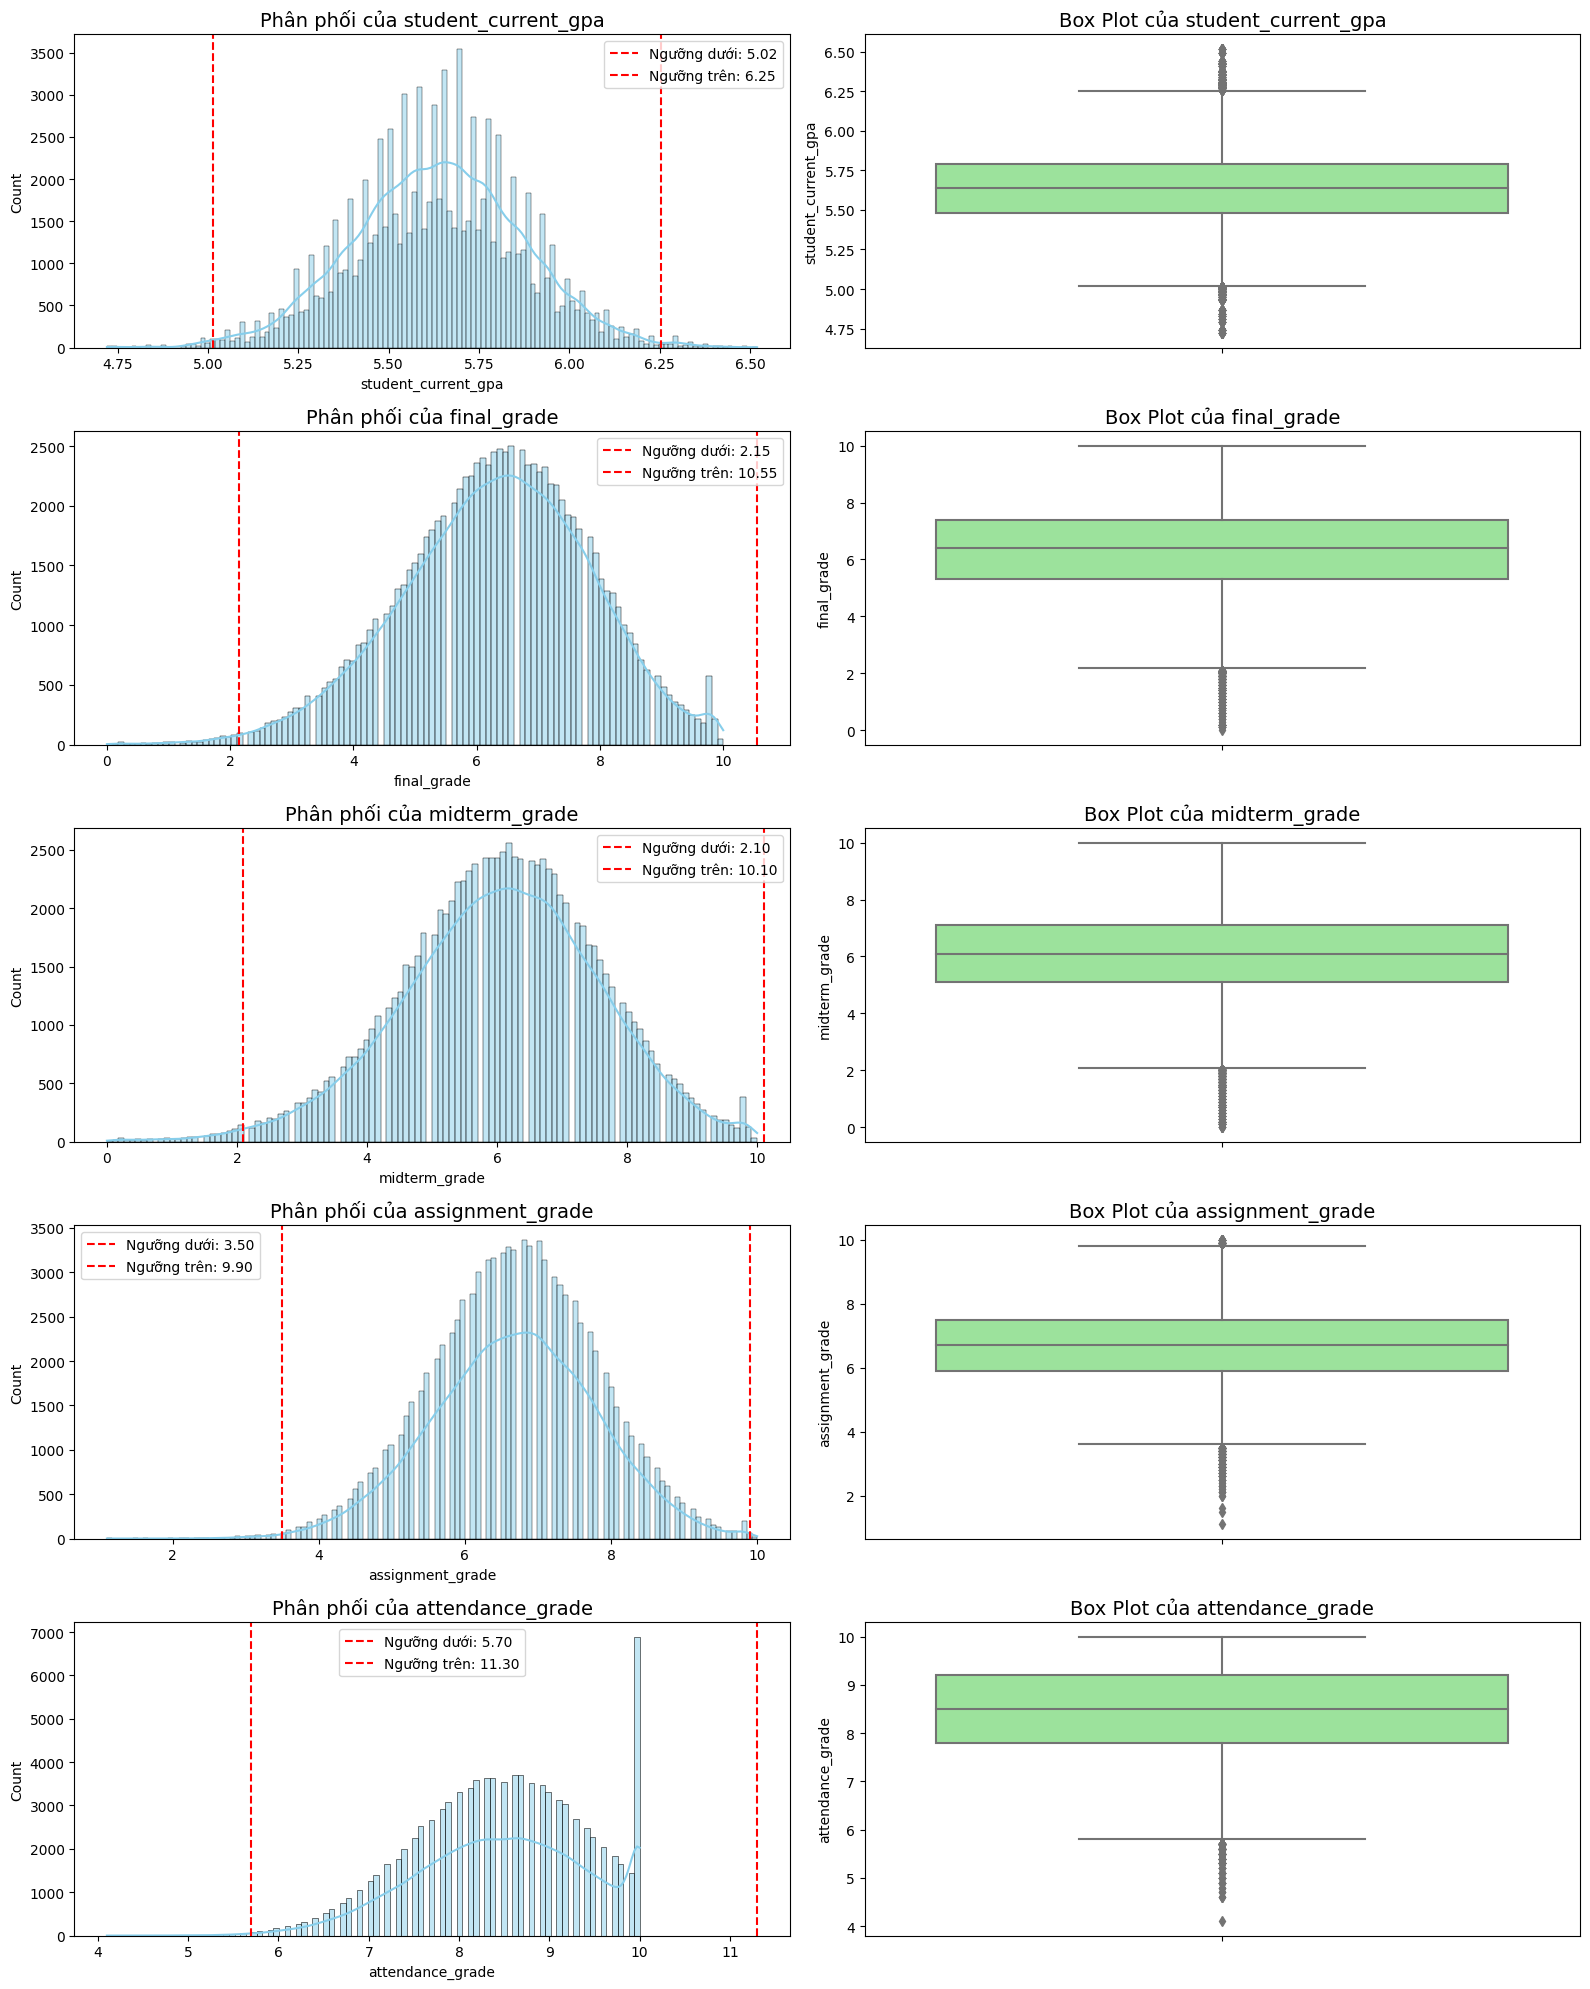

In [11]:
fig, axes = plt.subplots(len(numeric_columns_for_outliers), 2, figsize=(16, 4*len(numeric_columns_for_outliers)))

for i, column in enumerate(numeric_columns_for_outliers):
    # Vẽ histogram để thấy phân phối
    sns.histplot(df[column], kde=True, ax=axes[i, 0], color='skyblue')
    axes[i, 0].set_title(f'Phân phối của {column}', fontsize=14)
    axes[i, 0].axvline(outliers_summary[column]['lower_bound'], color='red', linestyle='--', 
                      label=f"Ngưỡng dưới: {outliers_summary[column]['lower_bound']:.2f}")
    axes[i, 0].axvline(outliers_summary[column]['upper_bound'], color='red', linestyle='--', 
                      label=f"Ngưỡng trên: {outliers_summary[column]['upper_bound']:.2f}")
    axes[i, 0].legend()
    
    # Vẽ boxplot để thấy rõ outliers
    sns.boxplot(y=df[column], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f'Box Plot của {column}', fontsize=14)
    axes[i, 1].set_ylabel(column)

plt.tight_layout()

### Xử lý outliers bằng phương pháp cắt bỏ (capping)


In [12]:
df_capped = df.copy()

for column in numeric_columns_for_outliers:
    lower_bound = outliers_summary[column]['lower_bound']
    upper_bound = outliers_summary[column]['upper_bound']
    
    # Cắt bỏ giá trị ngoại lai: thay thế bằng ngưỡng trên/dưới
    df_capped[column] = df_capped[column].clip(lower=lower_bound, upper=upper_bound)


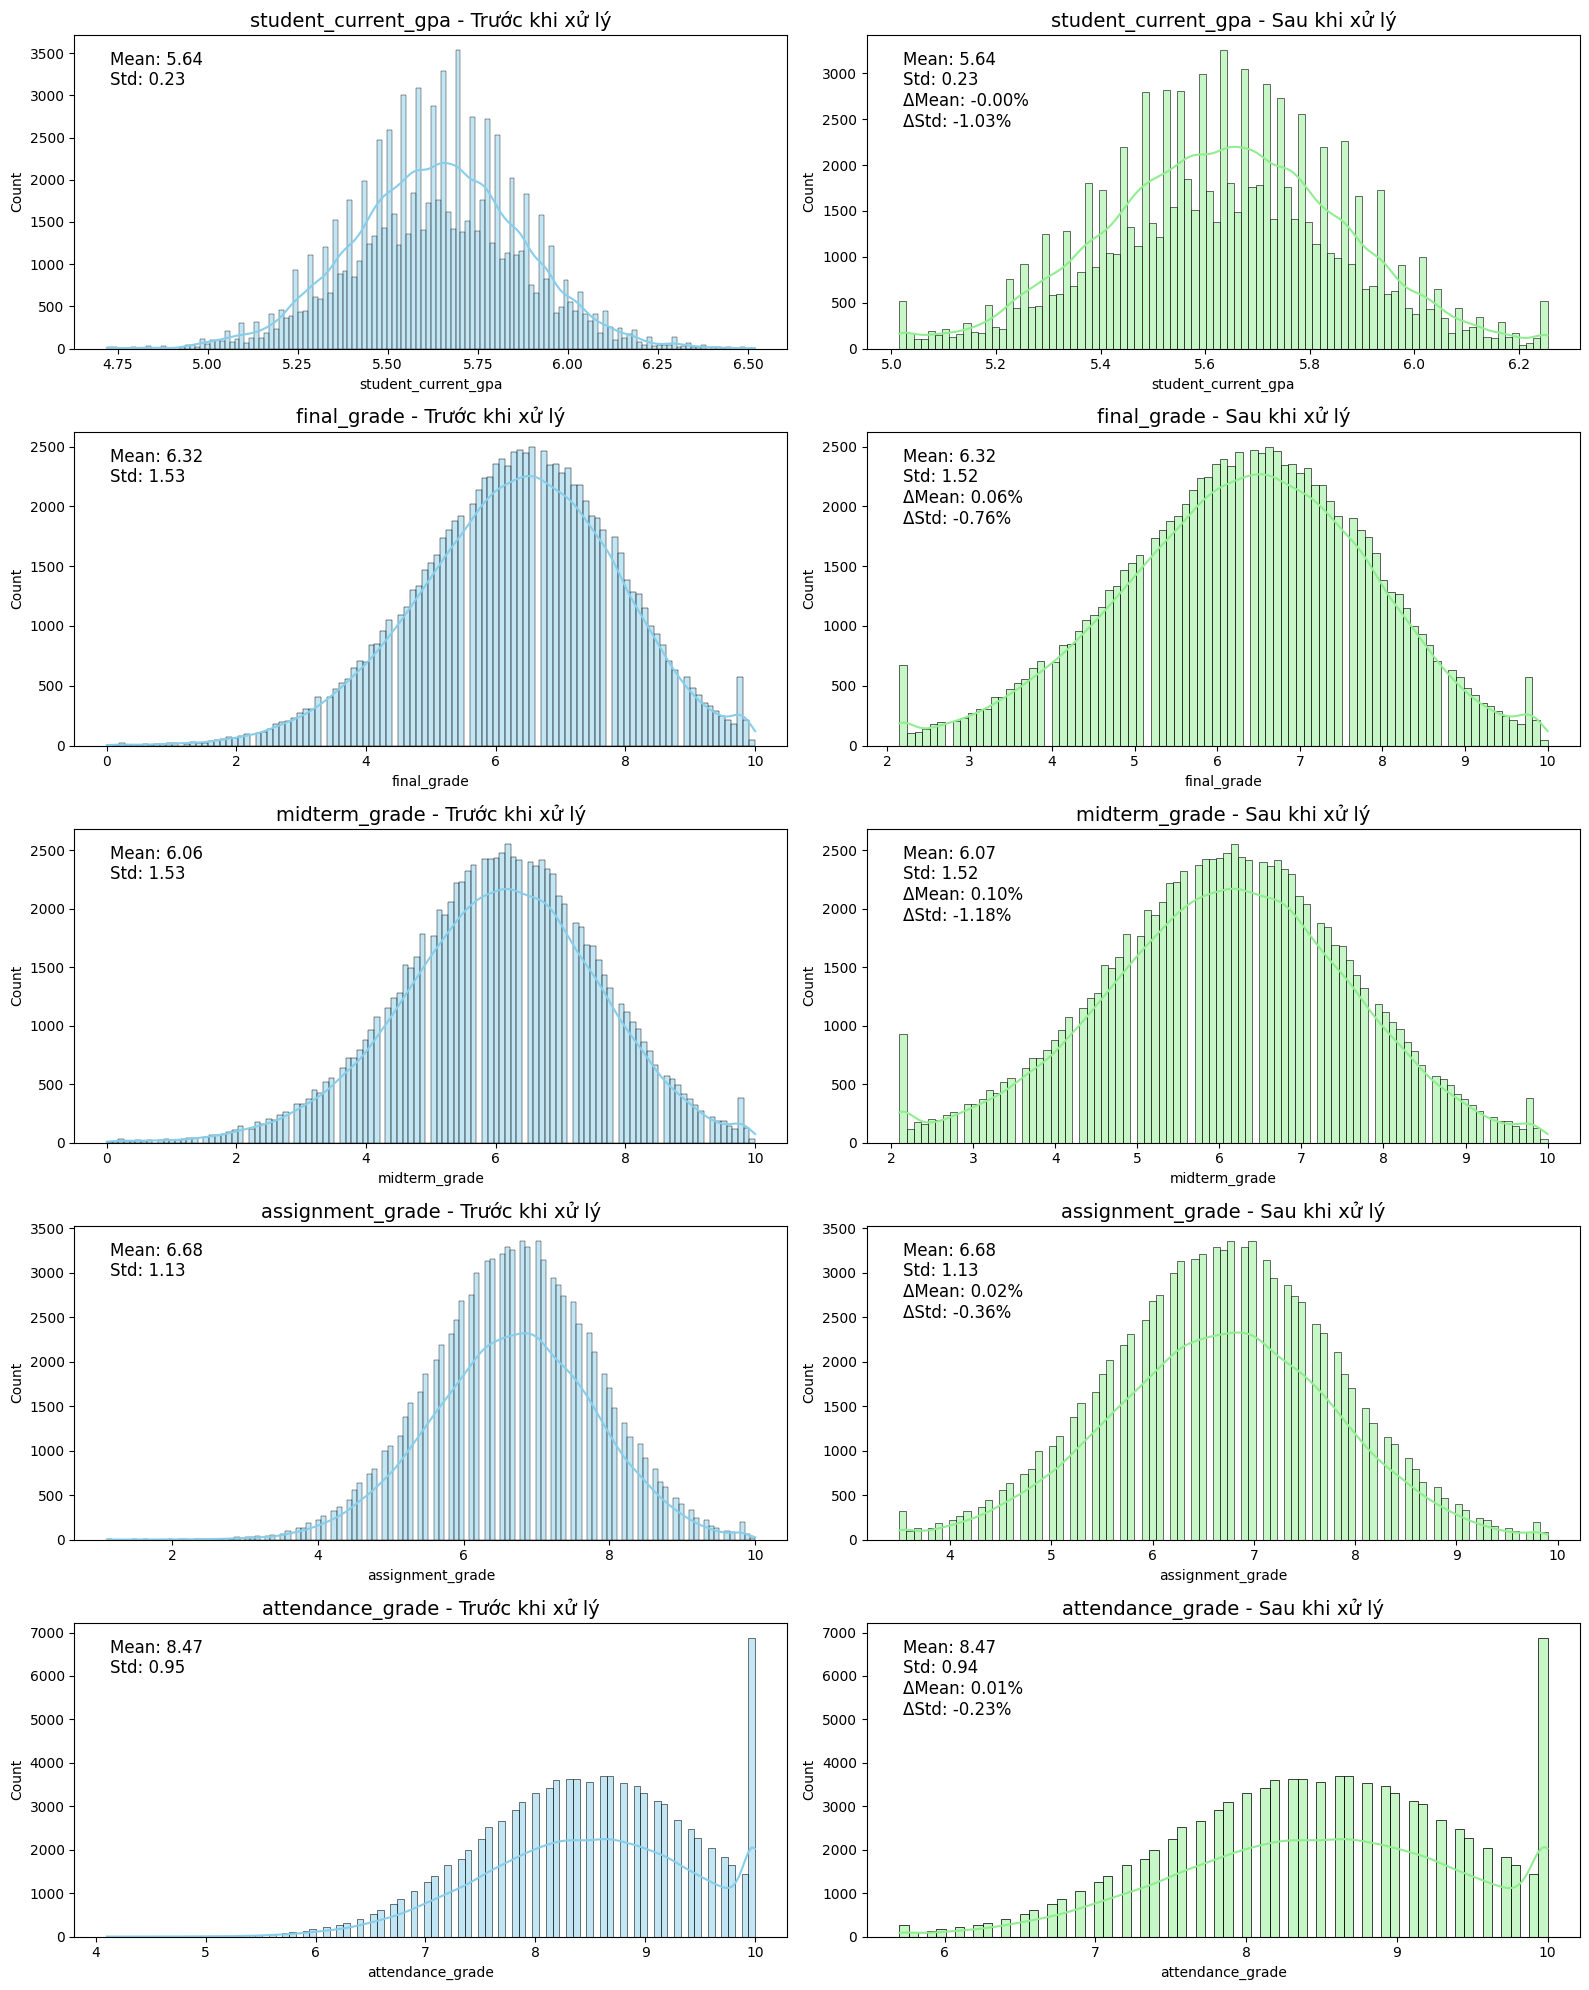

In [13]:
fig, axes = plt.subplots(len(numeric_columns_for_outliers), 2, figsize=(16, 4*len(numeric_columns_for_outliers)))

for i, column in enumerate(numeric_columns_for_outliers):
    # Histogram trước khi xử lý
    sns.histplot(df[column], kde=True, ax=axes[i, 0], color='skyblue', label='Original')
    axes[i, 0].set_title(f'{column} - Trước khi xử lý', fontsize=14)
    
    # Histogram sau khi xử lý
    sns.histplot(df_capped[column], kde=True, ax=axes[i, 1], color='lightgreen', label='After Capping')
    axes[i, 1].set_title(f'{column} - Sau khi xử lý', fontsize=14)
    
    # Thêm thông tin thay đổi
    change_mean = ((df_capped[column].mean() - df[column].mean()) / df[column].mean()) * 100
    change_std = ((df_capped[column].std() - df[column].std()) / df[column].std()) * 100
    
    axes[i, 0].text(0.05, 0.95, f"Mean: {df[column].mean():.2f}\nStd: {df[column].std():.2f}", 
                  transform=axes[i, 0].transAxes, va='top', fontsize=12)
    axes[i, 1].text(0.05, 0.95, f"Mean: {df_capped[column].mean():.2f}\nStd: {df_capped[column].std():.2f}\nΔMean: {change_mean:.2f}%\nΔStd: {change_std:.2f}%", 
                  transform=axes[i, 1].transAxes, va='top', fontsize=12)

plt.tight_layout()

**Kết luận**: Sau khi khám phá dữ liệu, nhận ra bộ dữ liệu không có giá trị bị thiếu cũng như giá trị trùng lặp. Đồng thời xử lý các giá trị ngoại lai bằng phương pháp cắt bỏ (capping).¶

In [14]:
df = df_capped.copy()

## 3. Phân tích phân bố chuyên ngành gợi ý (biến mục tiêu)

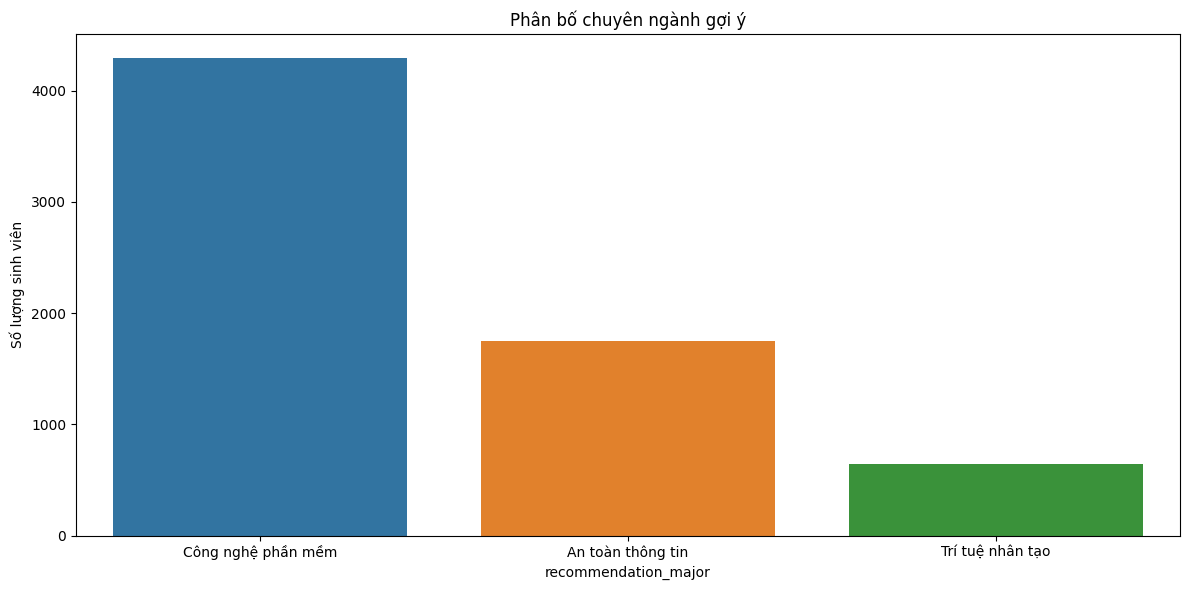

In [15]:
plt.figure(figsize=(12, 6))
major_counts = df.groupby('student_id')['recommendation_major'].first().value_counts()
sns.barplot(x=major_counts.index, y=major_counts.values)
plt.title('Phân bố chuyên ngành gợi ý')
plt.xticks()
plt.ylabel('Số lượng sinh viên')
plt.tight_layout()
plt.show()

Chuyên ngành Công nghệ phần mềm chiếm số lượng sinh viên áp đảo nhất (khoảng 4200 sinh viên), gấp hơn 2 lần so với chuyên ngành An toàn thông tin (khoảng 1750 sinh viên). Trí tuệ nhân tạo có số lượng sinh viên ít nhất, chỉ khoảng 600 sinh viên.

Sự chênh lệch lớn này cho thấy **Công nghệ phần mềm** đang là chuyên ngành được gợi ý nhiều nhất trong hệ thống, trong khi **Trí tuệ nhân tạo** có thể là chuyên ngành mới hoặc có tiêu chí gợi ý khắt khe hơn so với hai chuyên ngành còn lại.

## 4. Phân tích điểm trung bình theo chuyên ngành

### Tính điểm trung bình của mỗi sinh viên theo loại môn học


In [16]:
def get_student_avg_grades_by_subject_category(df):
    df['calculated_grade'] = (df['attendance_grade'] * df['attendance_percentage']/100 +
                             df['midterm_grade'] * df['midterm_percentage']/100 +
                             df['assignment_grade'] * df['assignment_percentage']/100 +
                             df['final_grade'] * df['final_percentage']/100)
    
    avg_grades = df.groupby(['student_id', 'subject_category'])['calculated_grade'].mean().unstack()
    
    return avg_grades

avg_grades_by_category = get_student_avg_grades_by_subject_category(df)
print("\nĐiểm trung bình theo loại môn học:")
print(avg_grades_by_category.head())


Điểm trung bình theo loại môn học:
subject_category  technique    theory  tool
student_id                                 
10000              6.860000  6.130714  4.32
10001              6.832500  6.345000  4.47
10002              7.108333  6.413333  5.23
10003              6.613333  6.481429  5.61
10004              6.311667  6.301250  4.69


### Phân tích điểm trung bình theo loại môn học và chuyên ngành


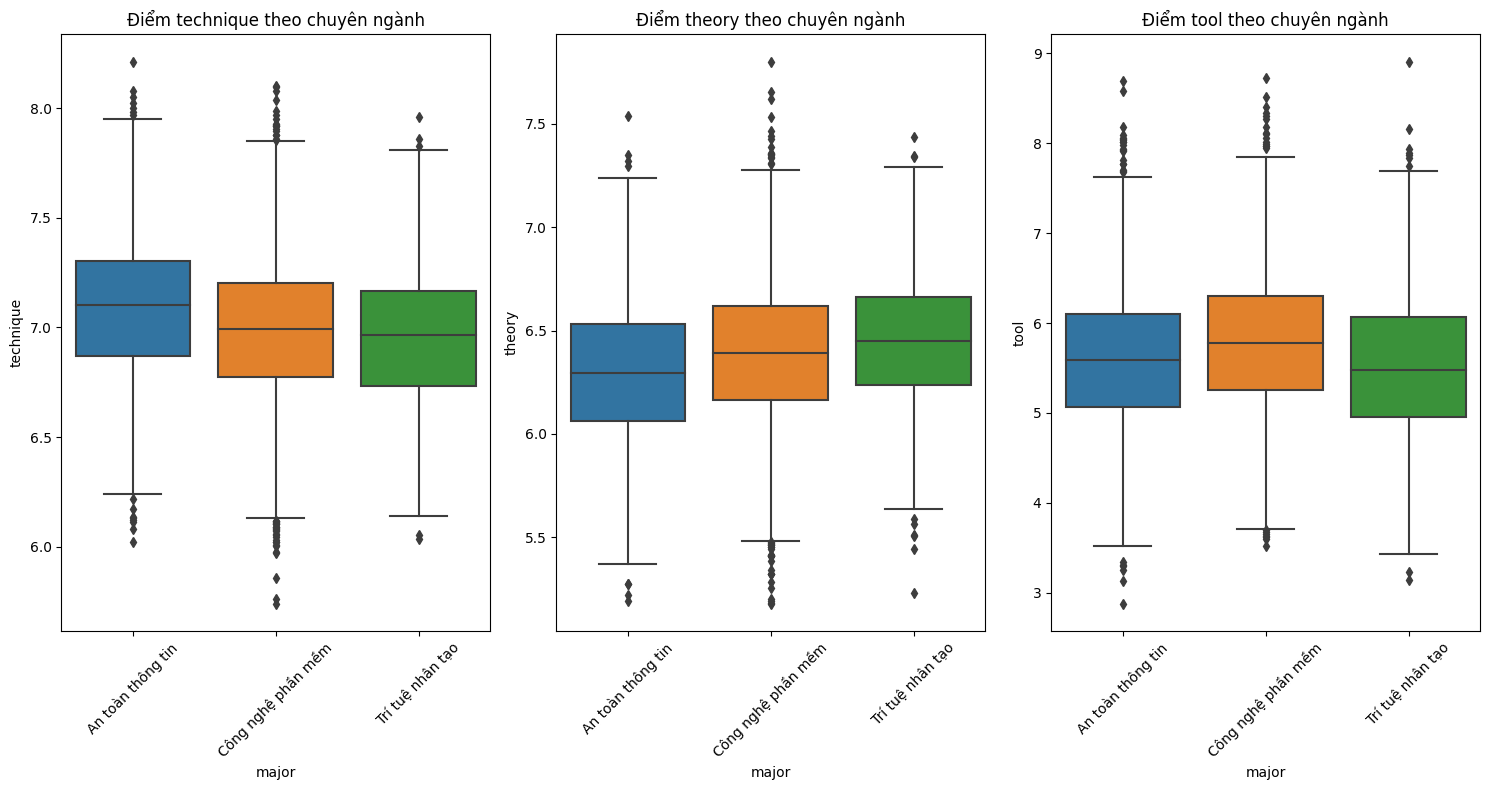

In [17]:
student_majors = df.groupby('student_id')['recommendation_major'].first()
avg_grades_by_category['major'] = student_majors

plt.figure(figsize=(15, 8))
for i, category in enumerate(avg_grades_by_category.columns[:-1]):
    plt.subplot(1, len(avg_grades_by_category.columns[:-1]), i+1)
    sns.boxplot(x='major', y=category, data=avg_grades_by_category.reset_index())
    plt.title(f'Điểm {category} theo chuyên ngành')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Qua ba biểu đồ này, có thể thấy mỗi chuyên ngành có điểm mạnh riêng: An toàn thông tin mạnh về kỹ thuật, Trí tuệ nhân tạo mạnh về lý thuyết, và Công nghệ phần mềm mạnh về sử dụng công cụ.

## 5. Phân tích kỹ năng của sinh viên

In [18]:
vectorizer = CountVectorizer(token_pattern=r'[^,\s]+')

all_skills = []
for skills in df['skill_list'].dropna().unique():
    all_skills.extend([skill.strip() for skill in skills.split(',')])
unique_skills = sorted(set(all_skills))

print(f"\nTổng số kỹ năng duy nhất: {len(unique_skills)}")
print("Một số kỹ năng phổ biến:")
print(unique_skills[:20])


Tổng số kỹ năng duy nhất: 37
Một số kỹ năng phổ biến:
['Bảo mật', 'Giao thức mạng', 'Giao tiếp', 'Giải quyết vấn đề', 'Kiểm thử', 'Làm việc nhóm', 'Lập trình', 'Lập trình OOP', 'Lập trình hệ thống', 'Machine Learning', 'Mã hóa', 'Mô hình hóa', 'Ngoại ngữ', 'Phân tích', 'Phân tích dữ liệu', 'Phân tích rủi ro', 'Phân tích tín hiệu', 'Process', 'Quy trình phát triển', 'Quản lý dữ liệu']


### Phân tích kỹ năng theo chuyên ngành


In [19]:
def get_skills_by_major(df):
    """Tập hợp các kỹ năng phổ biến theo chuyên ngành"""
    skills_by_major = {}
    
    for major in df['recommendation_major'].unique():
        major_skills = []
        for skills in df[df['recommendation_major'] == major]['skill_list'].dropna():
            major_skills.extend([skill.strip() for skill in skills.split(',')])
        
        # Đếm tần suất
        skill_counts = pd.Series(major_skills).value_counts()
        skills_by_major[major] = skill_counts
    
    return skills_by_major

skills_by_major = get_skills_by_major(df)

for major, skills in skills_by_major.items():
    print(f"\nTop 10 kỹ năng phổ biến cho chuyên ngành {major}:")
    print(skills.head(10))


Top 10 kỹ năng phổ biến cho chuyên ngành An toàn thông tin:
Giao tiếp            4484
Giải quyết vấn đề    4438
Lập trình            4135
Bảo mật              3472
Tư duy toán học      3046
Thuyết trình         2991
Tư duy logic         2916
Xử lý dữ liệu        2802
Phân tích rủi ro     1745
Mã hóa               1745
Name: count, dtype: int64

Top 10 kỹ năng phổ biến cho chuyên ngành Công nghệ phần mềm:
Lập trình            11801
Giải quyết vấn đề    11406
Giao tiếp            11304
Xử lý dữ liệu         7673
Tư duy logic          7665
Thuyết trình          7539
Tư duy toán học       7480
Bảo mật               7259
Kiểm thử              4258
Quản lý dự án         4258
Name: count, dtype: int64

Top 10 kỹ năng phổ biến cho chuyên ngành Trí tuệ nhân tạo:
Giao tiếp            1667
Giải quyết vấn đề    1638
Lập trình            1609
Xử lý dữ liệu        1236
Tư duy toán học      1127
Thuyết trình         1105
Tư duy logic         1083
Bảo mật               968
Tư duy phân tích      642
M

### Kết luận

1. Kỹ năng chung ở tất cả các ngành:
*  **Giao tiếp, Giải quyết vấn đề, và Lập trình** luôn nằm trong top 3 kỹ năng phổ biến nhất ở cả ba chuyên ngành, cho thấy đây là các kỹ năng nền tảng quan trọng trong lĩnh vực CNTT.
* Các kỹ năng mềm như **Thuyết trình và Tư duy logic** cũng phổ biến ở cả ba chuyên ngành.

2. Kỹ năng đặc trưng của từng ngành:

* An toàn thông tin: Nổi bật với các kỹ năng **Bảo mật** (xếp thứ 4), **Phân tích rủi ro và Mã hóa** (nằm trong top 10) - đây là những kỹ năng chuyên biệt không xuất hiện hoặc xếp hạng thấp hơn ở các ngành khác.
* Công nghệ phần mềm: Đặc trưng với **Kiểm thử và Quản lý dự án** trong top 10, phản ánh tính ứng dụng thực tế của ngành.
* Trí tuệ nhân tạo: Nổi bật với **Machine Learning và Tư duy phân tích** trong top 10, phù hợp với đặc thù ngành cần phân tích dữ liệu và xây dựng mô hình.
  
3. Mức độ phổ biến của kỹ năng:

* Công nghệ phần mềm có số lượng kỹ năng lớn nhất (Lập trình: 11801), phản ánh quy mô lớn của ngành này trong dữ liệu.
* Kỹ năng **Bảo mật** có thứ hạng cao nhất trong An toàn thông tin (thứ 4) so với các ngành khác, mặc dù về số tuyệt đối thì Công nghệ phần mềm có nhiều sinh viên có kỹ năng này hơn.

In [20]:
# random_student_id = df['student_id'].dropna().unique()[0]

# student_data = df[df['student_id'] == random_student_id]

## 6. Tạo tính năng cho mô hình gợi ý chuyên ngành

In [21]:
def create_feature_matrix(df):
    # Nhóm dữ liệu theo sinh viên
    students = df['student_id'].unique()
    subjects = df['subject_code'].unique()
    
    student_features = {}
    
    for student_id in students:
        student_data = df[df['student_id'] == student_id]
        
        # Trích xuất thông tin sinh viên
        # gpa = student_data['student_current_gpa'].iloc[0]
        # semester = student_data['student_current_semester'].iloc[0]
        
        # Tính điểm trung bình theo loại môn học
        avg_by_category = student_data.groupby('subject_category')['final_grade'].mean()
        categories = ['theory', 'technique', 'tool']
        category_grades = {}
        for category in categories:
            if category in avg_by_category:
                category_grades[f'avg_{category}'] = avg_by_category[category]
            else:
                category_grades[f'avg_{category}'] = 0
        
        # Tính điểm trung bình cho từng loại đánh giá
        avg_midterm = student_data['midterm_grade'].mean()
        avg_assignment = student_data['assignment_grade'].mean()
        avg_attendance = student_data['attendance_grade'].mean()
        
        # Đếm số lượng môn học theo loại
        subject_counts = student_data.groupby('subject_type').size()
        subject_types = ['core', 'general']
        type_counts = {}
        for subject_type in subject_types:
            if subject_type in subject_counts:
                type_counts[f'count_{subject_type}'] = subject_counts[subject_type]
            else:
                type_counts[f'count_{subject_type}'] = 0
        
        # Tính số môn học theo phân loại điểm
        grade_groups = {}
        grade_groups['count_average'] = len(student_data[(student_data['final_grade'] >= 3) & (student_data['final_grade'] < 6)])
        grade_groups['count_good'] = len(student_data[(student_data['final_grade'] >= 6) & (student_data['final_grade'] < 8)])
        grade_groups['count_excellent'] = len(student_data[student_data['final_grade'] >= 8])
        
        # Phần trăm môn học theo nhóm điểm
        total_subjects = len(student_data)
        if total_subjects > 0:
            grade_groups['percent_average'] = grade_groups['count_average'] / total_subjects * 100
            grade_groups['percent_good'] = grade_groups['count_good'] / total_subjects * 100
            grade_groups['percent_excellent'] = grade_groups['count_excellent'] / total_subjects * 100
        else:
            grade_groups['percent_average'] = 0
            grade_groups['percent_good'] = 0
            grade_groups['percent_excellent'] = 0
        
        # Tính số lần retake trung bình
        avg_retake = student_data['retake_count'].mean()
        
        # Tạo vector kỹ năng với phân loại mức độ thành thạo
        skill_grade_map = {}
        
        for _, row in student_data.iterrows():
            final_grade = row['final_grade']
            if not pd.isna(row['skill_list']):
                for skill in [s.strip() for s in row['skill_list'].split(',')]:
                    if skill not in skill_grade_map:
                        skill_grade_map[skill] = {'grades': [], 'counts': 0}
                    
                    skill_grade_map[skill]['grades'].append(final_grade)
                    skill_grade_map[skill]['counts'] += 1
        
        # Tính mức độ thành thạo kỹ năng dựa trên điểm trung bình
        skill_proficiency = {}
        for skill, data in skill_grade_map.items():
            avg_grade = sum(data['grades']) / len(data['grades']) if data['grades'] else 0
            count = data['counts']
            
            if avg_grade >= 8:
                proficiency = 3  # Giỏi
            elif avg_grade >= 6:
                proficiency = 2  # Khá
            elif avg_grade >= 3:
                proficiency = 1  # Trung bình
            else:
                proficiency = 0  # Yếu
            
            skill_proficiency[skill] = {
                'proficiency': proficiency * count,
                'count': count,
                'avg_grade': avg_grade
            }
        
        # Sắp xếp kỹ năng theo mức độ thành thạo (giỏi -> khá -> trung bình) và số lần xuất hiện
        sorted_skills = sorted(
            skill_proficiency.items(),
            key=lambda x: (x[1]['proficiency'], x[1]['count'], x[1]['avg_grade']),
            reverse=True
        )
        
        # Ghi lại tính năng cơ bản
        feature = {
            'student_id': student_id,
            # 'gpa': gpa,
            # 'semester': semester,
            'avg_midterm': avg_midterm,
            'avg_assignment': avg_assignment,
            'avg_attendance': avg_attendance,
            'avg_retake': avg_retake,
            'skill_count': len(skill_proficiency),
            'major': student_data['recommendation_major'].iloc[0]
        }
        
        # Thêm điểm trung bình theo loại môn học
        feature.update(category_grades)
        
        # Thêm số lượng môn học theo loại
        feature.update(type_counts)
        
        # Thêm thông tin phân nhóm điểm
        feature.update(grade_groups)
        
        for i, (skill, data) in enumerate(sorted_skills): 
            safe_skill_name = skill.replace(" ", "_").replace("-", "_").replace(".", "_")
            feature[f'skill_{safe_skill_name}'] = data['count']
            feature[f'skill_{safe_skill_name}_level'] = data['proficiency']
            feature[f'skill_{safe_skill_name}_grade'] = data['avg_grade']
        
        student_features[student_id] = feature
    
    feature_df = pd.DataFrame.from_dict(student_features, orient='index')
    
    return feature_df

feature_matrix = create_feature_matrix(df)


**Mô tả chi tiết quá trình trích xuất đặc trưng cho hệ thống đề xuất ngành học**

### Tổng quan

Đoạn mã đã được phát triển nhằm xây dựng một ma trận đặc trưng từ dữ liệu học tập của sinh viên, phục vụ cho việc đề xuất ngành học phù hợp. Hệ thống này phân tích lịch sử học tập của từng sinh viên, bao gồm các môn học đã hoàn thành, điểm số, kỹ năng đạt được, và nhiều chỉ số khác để tạo ra một bộ đặc trưng toàn diện cho mỗi sinh viên.

### Hệ thống trích xuất năm nhóm đặc trưng chính như sau:

1. Đặc trưng về điểm trung bình theo loại môn học
   
Các môn học được phân thành bốn loại chính: lý thuyết (theory), thực hành (technique), công cụ (tool). Việc tính toán điểm trung bình cho từng loại môn học giúp đánh giá năng lực của sinh viên trong các lĩnh vực khác nhau của chương trình đào tạo.

**Lý do:** Năng lực của sinh viên thường không đồng đều giữa các loại môn học khác nhau. Sinh viên có thể mạnh về thực hành nhưng yếu về lý thuyết, hoặc ngược lại. Thông tin này rất quan trọng để đề xuất ngành học phù hợp với điểm mạnh của họ.

2. Đặc trưng về điểm đánh giá theo từng phương thức
   
Phương pháp đánh giá trong giáo dục đại học thường đa dạng, bao gồm kiểm tra giữa kỳ, bài tập, và điểm danh. Mỗi phương thức đánh giá có thể phản ánh những khía cạnh khác nhau trong quá trình học tập của sinh viên.

**Lý do:** Phân tích các điểm đánh giá khác nhau giúp hiểu rõ hơn về phong cách học tập của sinh viên. Một sinh viên có điểm bài tập cao nhưng điểm thi thấp có thể phù hợp với những ngành đòi hỏi khả năng làm việc độc lập và sáng tạo, trong khi sinh viên có điểm thi cao nhưng điểm bài tập thấp có thể phù hợp với những ngành đòi hỏi tư duy phân tích và khả năng xử lý thông tin nhanh chóng.

3. Đặc trưng về phân bố loại môn học
   
Môn học trong chương trình đào tạo có thể được phân loại thành môn bắt buộc (core), đại cương (general). Tỷ lệ phân bố giữa các loại môn học này có thể cung cấp thông tin về sự linh hoạt và đa dạng trong lựa chọn học tập của sinh viên.

**Lý do:** Việc theo dõi số lượng môn học sinh viên đã hoàn thành theo từng loại giúp đánh giá mức độ kiên nhẫn và tính kỷ luật của sinh viên, đồng thời cung cấp thông tin về xu hướng và sở thích học tập. Sinh viên có nhiều môn tự chọn đa dạng có thể phù hợp với các ngành liên ngành hoặc ngành có tính linh hoạt cao.

4. Đặc trưng về phân nhóm điểm số
   
Hệ thống phân loại điểm số thành ba nhóm chính: trung bình (3-6 điểm), khá (6-8 điểm) và giỏi (trên 8 điểm). Đây là cách tiếp cận phổ biến trong đánh giá học tập tại Việt Nam.

**Lý do:** Phân tích phân bố điểm số không chỉ cung cấp thông tin về kết quả học tập mà còn giúp đánh giá mức độ ổn định trong học tập của sinh viên. Một sinh viên có tỷ lệ cao các môn học đạt điểm giỏi có thể phù hợp với những ngành đòi hỏi sự xuất sắc và chính xác cao, trong khi sinh viên có phân bố điểm đa dạng có thể phù hợp với những ngành đòi hỏi sự linh hoạt và khả năng thích ứng.

5. Đặc trưng về kỹ năng và mức độ thành thạo
   
Phần phức tạp nhất của quá trình trích xuất đặc trưng liên quan đến việc phân tích các kỹ năng mà sinh viên đã đạt được qua các môn học. Mỗi môn học có thể giúp sinh viên phát triển một hoặc nhiều kỹ năng, và mức độ thành thạo của mỗi kỹ năng được đánh giá dựa trên điểm số của các môn học liên quan.

**Lý do:** Đặc trưng kỹ năng là yếu tố quan trọng nhất trong việc đề xuất ngành học, vì nó phản ánh trực tiếp những gì sinh viên có thể làm được, không chỉ những gì họ biết. Bằng cách trích xuất không chỉ các kỹ năng mà còn cả mức độ thành thạo, hệ thống có thể so sánh cấu trúc kỹ năng của sinh viên với các yêu cầu kỹ năng của các ngành học khác nhau.

In [22]:
print(f"Shape của ma trận tính năng: {feature_matrix.shape}")

feature_matrix = feature_matrix.fillna(0)

Shape của ma trận tính năng: (6684, 129)


Dữ liệu trích xuất bao gồm: điểm trung bình điểm thành phần tất cả các môn của sinh viên, số lượng các kỹ năng và các cột kỹ năng mà sinh viên có được.

# Tiền xử lý và huấn luyện mô hình



Đang huấn luyện và so sánh các mô hình cho gợi ý chuyên ngành...
=== HUẤN LUYỆN VÀ SO SÁNH CÁC MÔ HÌNH ===

Đang huấn luyện mô hình: Logistic Regression
  Tham số tốt nhất: {'C': 1.0, 'max_iter': 1000, 'multi_class': 'auto', 'solver': 'lbfgs'}
  Độ chính xác CV: 0.9761
  Độ chính xác test: 0.9773

Đang huấn luyện mô hình: Random Forest
  Tham số tốt nhất: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
  Độ chính xác CV: 0.8957
  Độ chính xác test: 0.8947

Đang huấn luyện mô hình: KNN
  Tham số tốt nhất: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
  Độ chính xác CV: 0.8107
  Độ chính xác test: 0.8241

Đang huấn luyện mô hình: Neural Network
  Tham số tốt nhất: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 500}
  Độ chính xác CV: 0.9571
  Độ chính xác test: 0.9581

=== KẾT QUẢ SO SÁNH CÁC MÔ HÌNH ===
                 model  cv_accuracy  test_accuracy
0  Logistic Re

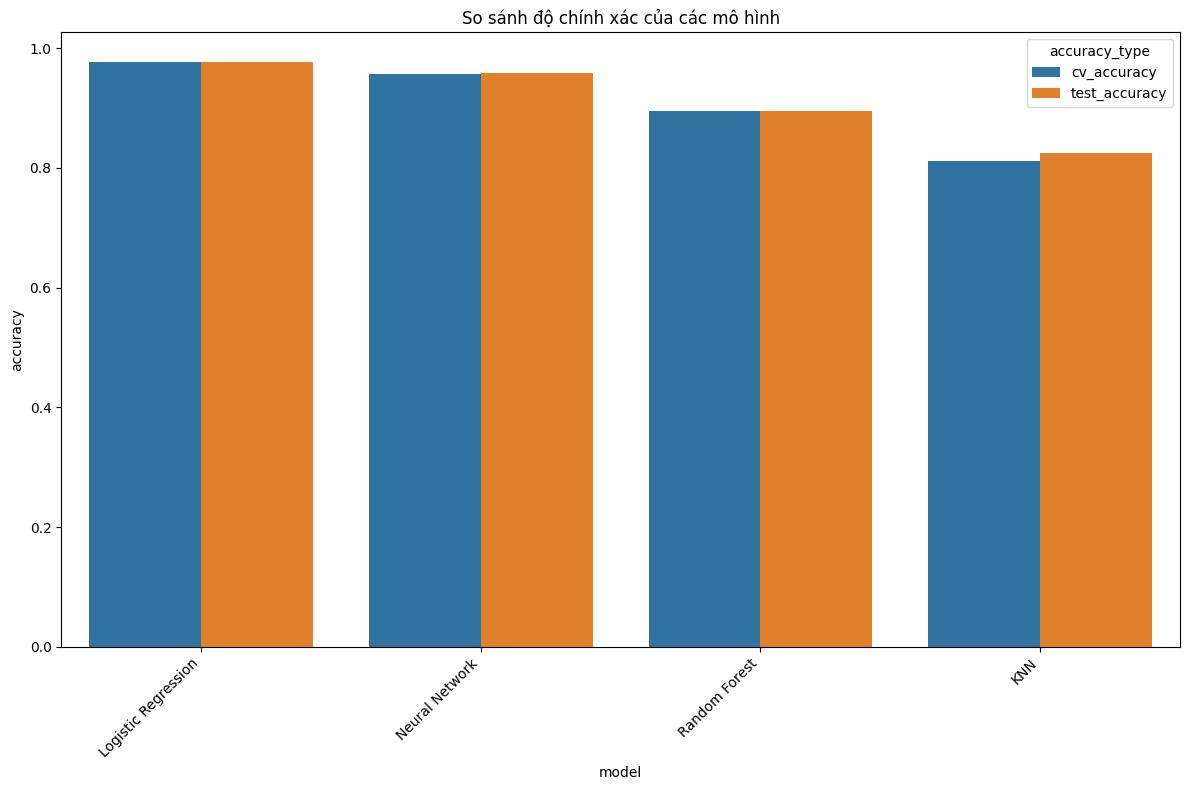


Mô hình tốt nhất: Logistic Regression
Độ chính xác: 0.9773

Báo cáo phân loại của mô hình tốt nhất:
                    precision    recall  f1-score   support

 An toàn thông tin       0.98      0.97      0.97       437
Công nghệ phần mềm       0.98      0.99      0.98      1074
  Trí tuệ nhân tạo       0.96      0.92      0.94       160

          accuracy                           0.98      1671
         macro avg       0.97      0.96      0.97      1671
      weighted avg       0.98      0.98      0.98      1671



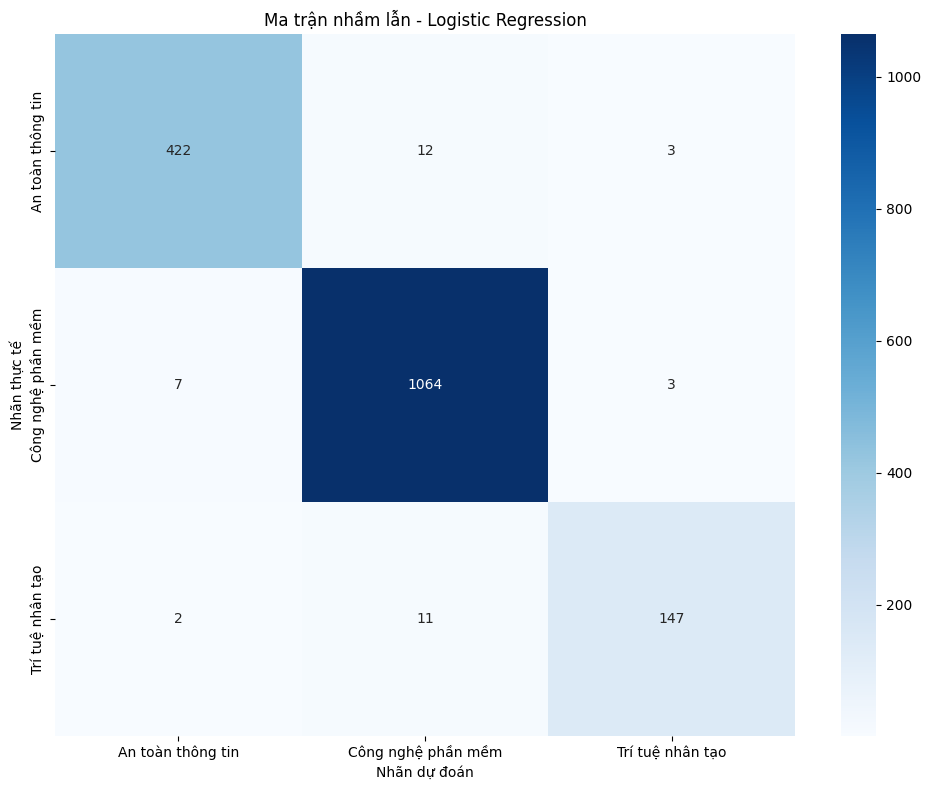


Tầm quan trọng của các tính năng:
                             feature  importance
42      skill_Machine_Learning_grade    2.153215
45      skill_Tư_duy_phân_tích_grade    2.153215
54                skill_Mã_hóa_grade    2.037226
57      skill_Phân_tích_rủi_ro_grade    2.037226
60  skill_Quy_trình_phát_triển_grade    1.955648
66         skill_Quản_lý_dự_án_grade    1.955648
63              skill_Kiểm_thử_grade    1.955648
21               skill_Bảo_mật_grade    1.647048
28                   skill_Lập_trình    1.246998
36         skill_Quản_trị_mạng_grade    1.040106
39        skill_Giao_thức_mạng_grade    1.040106
22             skill_Tư_duy_toán_học    1.009347
78    skill_Phân_tích_tín_hiệu_grade    0.984755
27         skill_Xử_lý_dữ_liệu_grade    0.961231
19                     skill_Bảo_mật    0.867466


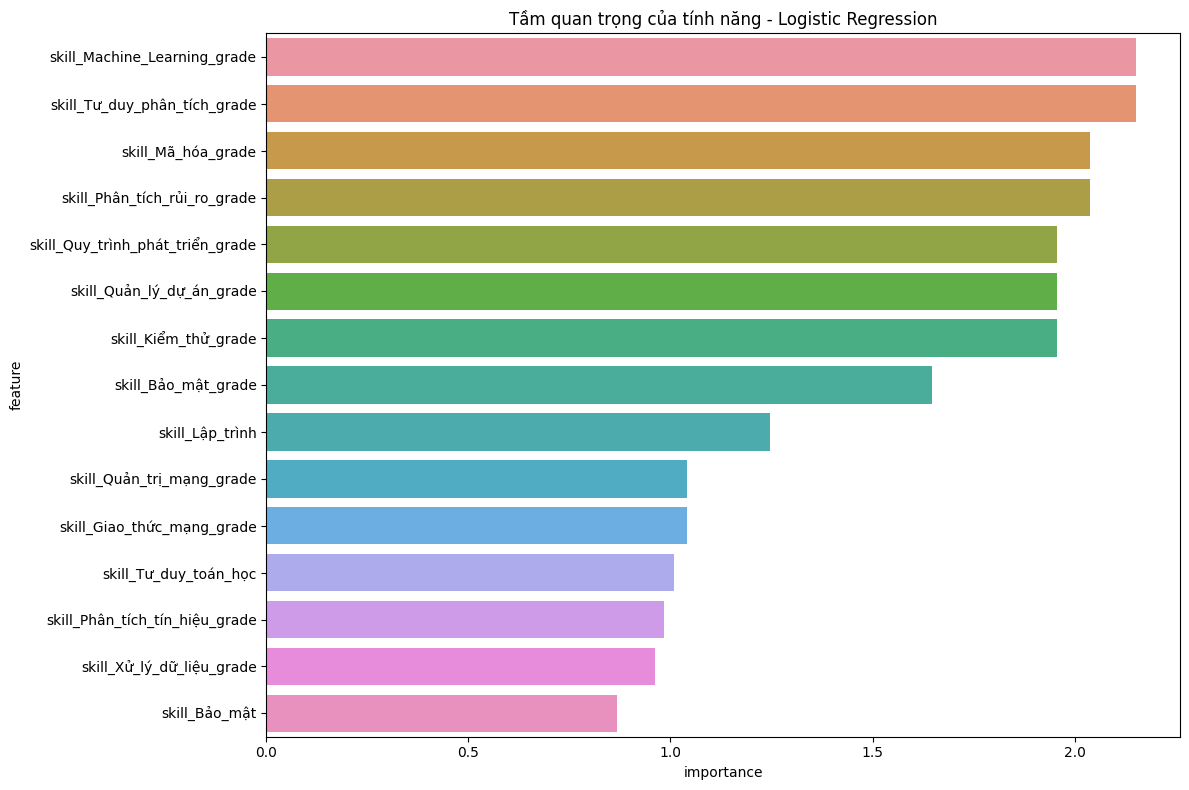

In [23]:
def train_multiple_models(feature_matrix):
    X = feature_matrix.drop(['student_id', 'major'], axis=1)
    y = feature_matrix['major']
    
    # Chia tập huấn luyện và kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    
    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Định nghĩa các mô hình và tham số tương ứng để thử nghiệm
    models = {
        'Logistic Regression': {
            'model': LogisticRegression(random_state=42),
            'params': {
                'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                'solver': ['liblinear', 'lbfgs', 'saga'],
                'max_iter': [1000],
                'multi_class': ['auto', 'ovr', 'multinomial']
            }
        },
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [200],
                'max_depth': [30],
                'min_samples_split': [10],
                'min_samples_leaf': [4]
            }
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7, 9, 11],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan', 'minkowski']
            }
        },
        'Neural Network': {
            'model': MLPClassifier(random_state=42),
            'params': {
                'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                'activation': ['relu', 'tanh'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'adaptive'],
                'max_iter': [500]
            }
        }
    }
    
    results = []
    best_models = {}
    
    # Tạo cross-validator với stratified K-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print("=== HUẤN LUYỆN VÀ SO SÁNH CÁC MÔ HÌNH ===")
    
    # Thử nghiệm từng mô hình
    for model_name, model_info in models.items():
        print(f"\nĐang huấn luyện mô hình: {model_name}")
        
        # Tìm tham số tốt nhất với GridSearchCV
        grid_search = GridSearchCV(
            estimator=model_info['model'],
            param_grid=model_info['params'],
            cv=cv,
            scoring='accuracy',
            verbose=0,
            n_jobs=-1  # Sử dụng tất cả CPU cores
        )
        
        # Chạy grid search
        grid_search.fit(X_train_scaled, y_train)
        
        # Lưu kết quả tham số tốt nhất
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        best_model = grid_search.best_estimator_
        
        # Đánh giá trên tập test
        y_pred = best_model.predict(X_test_scaled)
        test_accuracy = accuracy_score(y_test, y_pred)
        
        # Lưu kết quả
        results.append({
            'model': model_name,
            'best_params': best_params,
            'cv_accuracy': best_score,
            'test_accuracy': test_accuracy
        })
        
        # Lưu mô hình tốt nhất
        best_models[model_name] = {
            'model': best_model,
            'cv_accuracy': best_score,
            'test_accuracy': test_accuracy
        }
        
        print(f"  Tham số tốt nhất: {best_params}")
        print(f"  Độ chính xác CV: {best_score:.4f}")
        print(f"  Độ chính xác test: {test_accuracy:.4f}")
    
    # Sắp xếp kết quả theo độ chính xác trên tập test
    results_df = pd.DataFrame(results).sort_values('test_accuracy', ascending=False)
    
    print("\n=== KẾT QUẢ SO SÁNH CÁC MÔ HÌNH ===")
    print(results_df[['model', 'cv_accuracy', 'test_accuracy']])
    
    # Hiển thị biểu đồ so sánh độ chính xác của các mô hình
    plt.figure(figsize=(12, 8))
    comparison_df = results_df[['model', 'cv_accuracy', 'test_accuracy']].melt(
        id_vars='model', 
        var_name='accuracy_type', 
        value_name='accuracy'
    )
    sns.barplot(x='model', y='accuracy', hue='accuracy_type', data=comparison_df)
    plt.xticks(rotation=45, ha='right')
    plt.title('So sánh độ chính xác của các mô hình')
    plt.tight_layout()
    plt.show()
    
    # Lấy mô hình tốt nhất
    best_model_name = results_df.iloc[0]['model']
    best_model = best_models[best_model_name]['model']
    print(f"\nMô hình tốt nhất: {best_model_name}")
    print(f"Độ chính xác: {best_models[best_model_name]['test_accuracy']:.4f}")
    
    # Đánh giá chi tiết mô hình tốt nhất
    y_pred = best_model.predict(X_test_scaled)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print("\nBáo cáo phân loại của mô hình tốt nhất:")
    print(report)
    
    # Hiển thị ma trận nhầm lẫn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.title(f'Ma trận nhầm lẫn - {best_model_name}')
    plt.xlabel('Nhãn dự đoán')
    plt.ylabel('Nhãn thực tế')
    plt.tight_layout()
    plt.show()
    
    # Phân tích tầm quan trọng của tính năng (nếu mô hình hỗ trợ)
    try:
        if hasattr(best_model, 'feature_importances_'):
            # Cho Random Forest, GBM, XGBoost, etc.
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=False)
        elif hasattr(best_model, 'coef_'):
            # Cho Logistic Regression, SVM với kernel tuyến tính
            coefficients = best_model.coef_
            avg_importance = np.mean(np.abs(coefficients), axis=0)
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': avg_importance
            }).sort_values('importance', ascending=False)
        else:
            raise AttributeError("Mô hình không có thuộc tính feature_importances_ hoặc coef_")
        
        print("\nTầm quan trọng của các tính năng:")
        print(feature_importance.head(15))
        
        # Hiển thị biểu đồ tầm quan trọng
        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
        plt.title(f'Tầm quan trọng của tính năng - {best_model_name}')
        plt.tight_layout()
        plt.show()
    except (AttributeError, Exception) as e:
        print(f"\nKhông thể phân tích tầm quan trọng của tính năng: {e}")
    
    return best_model, scaler, best_models

# Huấn luyện nhiều mô hình và chọn ra mô hình tốt nhất
print("\nĐang huấn luyện và so sánh các mô hình cho gợi ý chuyên ngành...")
major_model, major_scaler, all_models = train_multiple_models(feature_matrix)


In [24]:
# import joblib
# import os

# # Tạo thư mục để lưu mô hình nếu chưa tồn tại
# os.makedirs('models', exist_ok=True)

# # Sau khi đã huấn luyện mô hình tốt nhất (major_model và major_scaler)
# # Thêm đoạn mã này vào cuối quá trình huấn luyện

# print("Đang lưu mô hình tốt nhất...")
# joblib.dump(major_model, 'models/major_model.pkl')
# joblib.dump(major_scaler, 'models/major_scaler.pkl')

# # Lưu feature_matrix để sử dụng cho việc gợi ý
# feature_matrix.reset_index().to_csv('models/feature_matrix.csv', index=False)

# print("Đã lưu mô hình thành công!")

# Demo

## 1. Hàm gợi ý chuyên ngành cho sinh viên mới


In [25]:
def recommend_major(student_id, df, model, scaler, feature_matrix, top_n=3):
    """Gợi ý chuyên ngành cho sinh viên dựa trên dữ liệu hiện có"""
    if student_id not in feature_matrix.index:
        print(f"Không tìm thấy sinh viên với ID {student_id}")
        return None
    
    # Lấy thông tin sinh viên
    student_features = feature_matrix.loc[student_id].drop(['student_id', 'major'])
    
    # Chuẩn hóa tính năng
    student_features_scaled = scaler.transform(student_features.values.reshape(1, -1))
    
    # Dự đoán xác suất cho mỗi chuyên ngành
    major_probs = model.predict_proba(student_features_scaled)[0]
    
    # Sắp xếp theo xác suất
    major_predictions = pd.DataFrame({
        'major': model.classes_,
        'probability': major_probs
    }).sort_values('probability', ascending=False)
    
    # Lấy top N chuyên ngành
    top_majors = major_predictions.head(top_n)
    
    # Phân tích kỹ năng của sinh viên
    student_data = df[df['student_id'] == student_id]
    student_skills = []
    
    for skill_list in student_data['skill_list'].dropna():
        student_skills.extend([skill.strip() for skill in skill_list.split(',')])
    
    student_skill_counts = pd.Series(student_skills).value_counts()
    
    # Điểm số môn học của sinh viên
    subject_grades = student_data[['subject_code', 'subject_name', 'final_grade']].sort_values('final_grade', ascending=False)
    
    # Thêm phân tích lý do gợi ý
    top_majors_analysis = []
    
    for _, row in top_majors.iterrows():
        major = row['major']
        probability = row['probability']
        
        # Tìm các kỹ năng phù hợp với chuyên ngành
        major_top_skills = skills_by_major[major].head(10).index
        matching_skills = set(student_skill_counts.index) & set(major_top_skills)
        
        # Tìm môn học mạnh phù hợp với chuyên ngành
        major_students = feature_matrix[feature_matrix['major'] == major].index
        major_subjects = df[df['student_id'].isin(major_students)]['subject_code'].value_counts().head(10).index
        strong_subjects = subject_grades[subject_grades['subject_code'].isin(major_subjects) & 
                                        (subject_grades['final_grade'] >= 7)]
        
        top_majors_analysis.append({
            'major': major,
            'probability': probability,
            'matching_skills': list(matching_skills),
            'strong_subjects': strong_subjects
        })
    
    return top_majors, top_majors_analysis

## 2. Tạo hàm đề xuất môn học cần cải thiện dựa trên chuyên ngành mục tiêu

In [26]:

def recommend_subjects_to_improve(student_id, target_major, df, feature_matrix):
    """Đề xuất các môn học cần cải thiện để phù hợp hơn với chuyên ngành mục tiêu"""
    if student_id not in feature_matrix.index:
        print(f"Không tìm thấy sinh viên với ID {student_id}")
        return None
    
    # Lấy thông tin sinh viên
    student_data = df[df['student_id'] == student_id]
    
    # Lấy danh sách môn học của sinh viên
    student_subjects = student_data[['subject_code', 'subject_name', 'final_grade']]
    
    # Lấy thông tin về sinh viên cùng chuyên ngành mục tiêu
    target_major_students = feature_matrix[feature_matrix['major'] == target_major].index
    
    # Tìm các môn học phổ biến trong chuyên ngành mục tiêu
    target_major_subjects = df[df['student_id'].isin(target_major_students)].groupby('subject_code').agg({
        'subject_name': 'first',
        'final_grade': 'mean',
        'student_id': 'count'
    }).reset_index()
    
    # Sắp xếp theo số lượng sinh viên để tìm môn học phổ biến
    target_major_subjects = target_major_subjects.sort_values('student_id', ascending=False)
    target_major_subjects.rename(columns={'student_id': 'student_count'}, inplace=True)
    
    # Lọc các môn học phổ biến (học bởi ít nhất 10% sinh viên trong chuyên ngành)
    min_students = len(target_major_students) * 0.1
    popular_subjects = target_major_subjects[target_major_subjects['student_count'] >= min_students]
    
    # So sánh với các môn học của sinh viên
    student_subject_codes = student_subjects['subject_code'].values
    
    # Tìm các môn học phổ biến mà sinh viên chưa học
    new_subjects = popular_subjects[~popular_subjects['subject_code'].isin(student_subject_codes)].head(5)
    
    # Tìm các môn học có điểm thấp cần cải thiện
    subjects_to_improve = pd.merge(
        student_subjects,
        popular_subjects,
        on='subject_code',
        suffixes=('_student', '_target')
    )
    
    # Tính điểm chênh lệch
    subjects_to_improve['grade_difference'] = subjects_to_improve['final_grade_target'] - subjects_to_improve['final_grade_student']
    
    # Lọc những môn có điểm thấp hơn trung bình chuyên ngành
    subjects_to_improve = subjects_to_improve[subjects_to_improve['grade_difference'] > 1].sort_values('grade_difference', ascending=False)
    
    return new_subjects, subjects_to_improve

## 3. Hệ thống gợi ý toàn diện

In [27]:
def comprehensive_recommendation(student_id, df, model, scaler, feature_matrix):
    """Cung cấp gợi ý toàn diện cho sinh viên bao gồm chuyên ngành và môn học cần cải thiện"""
    # Lấy thông tin sinh viên
    student_info = df[df['student_id'] == student_id][['student_id', 'student_name', 'student_current_semester', 'student_current_gpa']].drop_duplicates().iloc[0]
    
    print(f"THÔNG TIN SINH VIÊN:")
    print(f"ID: {student_info['student_id']}")
    print(f"Tên: {student_info['student_name']}")
    print(f"Học kỳ: {student_info['student_current_semester']}")
    print(f"GPA: {student_info['student_current_gpa']}")
    
    # Lấy chuyên ngành hiện tại nếu có
    current_major = feature_matrix.loc[student_id, 'major'] if student_id in feature_matrix.index else "Chưa xác định"
    print(f"Chuyên ngành hiện tại: {current_major}")
    
    # Gợi ý chuyên ngành
    print("\nGỢI Ý CHUYÊN NGÀNH:")
    top_majors, major_analysis = recommend_major(student_id, df, model, scaler, feature_matrix)
    
    if top_majors is not None:
        for i, (_, major_row) in enumerate(top_majors.iterrows()):
            print(f"{i+1}. {major_row['major']} (Xác suất: {major_row['probability']:.2f})")
            
            # In phân tích chi tiết
            analysis = major_analysis[i]
            
            print(f"   Kỹ năng phù hợp: {', '.join(analysis['matching_skills'][:5])}")
            
            if not analysis['strong_subjects'].empty:
                print("   Môn học mạnh:")
                for _, subj_row in analysis['strong_subjects'].head(3).iterrows():
                    print(f"     - {subj_row['subject_name']} (Điểm: {subj_row['final_grade']:.1f})")
    
    # Lấy chuyên ngành được gợi ý đầu tiên để phân tích môn học cần cải thiện
    if top_majors is not None and len(top_majors) > 0:
        target_major = top_majors.iloc[0]['major']
        
        # Gợi ý môn học mới và môn học cần cải thiện
        print(f"\nGỢI Ý MÔN HỌC CHO CHUYÊN NGÀNH {target_major}:")
        new_subjects, improve_subjects = recommend_subjects_to_improve(student_id, target_major, df, feature_matrix)
        
        print("\nMôn học phổ biến chưa học:")
        for _, row in new_subjects.iterrows():
            print(f"- {row['subject_name']} (Điểm trung bình ngành: {row['final_grade']:.1f})")
        
        print("\nMôn học cần cải thiện:")
        for _, row in improve_subjects.head(5).iterrows():
            print(f"- {row['subject_name_student']} (Điểm hiện tại: {row['final_grade_student']:.1f}, Điểm trung bình ngành: {row['final_grade_target']:.1f})")


### Demo với một số sinh viên

In [28]:
warnings.filterwarnings('ignore')

print("\n" + "="*50)
print("DEMO HỆ THỐNG GỢI Ý CHUYÊN NGÀNH")
print("="*50)

demo_students = [10000, 10010, 10020, 10030, 10040]

for student_id in demo_students:
    print("\n" + "="*50)
    print(f"DEMO VỚI SINH VIÊN ID: {student_id}")
    print("="*50)
    comprehensive_recommendation(student_id, df, major_model, major_scaler, feature_matrix)


DEMO HỆ THỐNG GỢI Ý CHUYÊN NGÀNH

DEMO VỚI SINH VIÊN ID: 10000
THÔNG TIN SINH VIÊN:
ID: 10000
Tên: Vũ Quang Phương
Học kỳ: 5
GPA: 5.35
Chuyên ngành hiện tại: An toàn thông tin

GỢI Ý CHUYÊN NGÀNH:
1. An toàn thông tin (Xác suất: 0.98)
   Kỹ năng phù hợp: Giải quyết vấn đề, Bảo mật, Giao tiếp, Phân tích rủi ro, Thuyết trình
   Môn học mạnh:
     - Giải tích (Điểm: 8.6)
     - Mạng máy tính (Điểm: 8.5)
2. Công nghệ phần mềm (Xác suất: 0.02)
   Kỹ năng phù hợp: Quản lý dự án, Giải quyết vấn đề, Bảo mật, Xử lý dữ liệu, Thuyết trình
3. Trí tuệ nhân tạo (Xác suất: 0.00)
   Kỹ năng phù hợp: Giải quyết vấn đề, Bảo mật, Xử lý dữ liệu, Thuyết trình, Tư duy toán học
   Môn học mạnh:
     - Giải tích (Điểm: 8.6)
     - Nhập môn trí tuệ nhân tạo (Điểm: 8.2)

GỢI Ý MÔN HỌC CHO CHUYÊN NGÀNH An toàn thông tin:

Môn học phổ biến chưa học:
- Tiếng Anh (Điểm trung bình ngành: 6.1)

Môn học cần cải thiện:
- Cấu trúc dữ liệu và giải thuật (Điểm hiện tại: 2.1, Điểm trung bình ngành: 5.9)
- Lập trình hướng 

### Demo với một sinh viên cụ thể


In [29]:
def demo_specific_student(student_id):
    print("\n" + "="*50)
    print(f"PHÂN TÍCH CHI TIẾT CHO SINH VIÊN ID: {student_id}")
    print("="*50)
    comprehensive_recommendation(student_id, df, major_model, major_scaler, feature_matrix)
    
    # Hiển thị thêm thông tin chi tiết
    student_data = df[df['student_id'] == student_id]
    
    # Thống kê theo loại môn học
    print("\nĐiểm trung bình theo loại môn học:")
    print(student_data.groupby('subject_category')['final_grade'].mean())
    
    # Phân tích kỹ năng
    print("\nDanh sách kỹ năng:")
    student_skills = []
    for skill_list in student_data['skill_list'].dropna():
        student_skills.extend([skill.strip() for skill in skill_list.split(',')])
    
    for skill, count in pd.Series(student_skills).value_counts().items():
        print(f"- {skill}: {count}")
    
    print("\nTất cả môn học và điểm:")
    subject_grades = student_data[['subject_code', 'subject_name', 'final_grade']].sort_values('final_grade', ascending=False)
    print(subject_grades)

# Demo với một sinh viên cụ thể
specific_student = 10000  
demo_specific_student(specific_student)


PHÂN TÍCH CHI TIẾT CHO SINH VIÊN ID: 10000
THÔNG TIN SINH VIÊN:
ID: 10000
Tên: Vũ Quang Phương
Học kỳ: 5
GPA: 5.35
Chuyên ngành hiện tại: An toàn thông tin

GỢI Ý CHUYÊN NGÀNH:
1. An toàn thông tin (Xác suất: 0.98)
   Kỹ năng phù hợp: Giải quyết vấn đề, Bảo mật, Giao tiếp, Phân tích rủi ro, Thuyết trình
   Môn học mạnh:
     - Giải tích (Điểm: 8.6)
     - Mạng máy tính (Điểm: 8.5)
2. Công nghệ phần mềm (Xác suất: 0.02)
   Kỹ năng phù hợp: Quản lý dự án, Giải quyết vấn đề, Bảo mật, Xử lý dữ liệu, Thuyết trình
3. Trí tuệ nhân tạo (Xác suất: 0.00)
   Kỹ năng phù hợp: Giải quyết vấn đề, Bảo mật, Xử lý dữ liệu, Thuyết trình, Tư duy toán học
   Môn học mạnh:
     - Giải tích (Điểm: 8.6)
     - Nhập môn trí tuệ nhân tạo (Điểm: 8.2)

GỢI Ý MÔN HỌC CHO CHUYÊN NGÀNH An toàn thông tin:

Môn học phổ biến chưa học:
- Tiếng Anh (Điểm trung bình ngành: 6.1)

Môn học cần cải thiện:
- Cấu trúc dữ liệu và giải thuật (Điểm hiện tại: 2.1, Điểm trung bình ngành: 5.9)
- Lập trình hướng đối tượng (Điểm hiện